<a href="https://colab.research.google.com/github/lattmi/Latta/blob/main/HouseSalePriceXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xgboost

In [2]:
!pip3 install sklearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor

%matplotlib inline


# **Data Processing**

In [4]:
# load the data
df = pd.read_csv('housing_price_small.csv')

# drop useless column(s)
df = df.drop(columns = 'Id')

# replace NA with 0
#df = df.fillna(0)

# check shape
df.shape


(1460, 80)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### Split data into categorical and numeric
 

In [6]:
# categorical if unique values less than n
n = 50

df_categ = df.nunique()[df.nunique() < n].keys().tolist()
df_num = [x for x in df.columns if x not in df_categ] 

In [7]:
df_categ

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

### Split train and test

In [8]:
# shuffle input data
df = df.sample(frac=1).reset_index(drop=True)

# train and test sets
train_dataset = df.sample(frac=0.8, random_state=1)
test_dataset = df.drop(train_dataset.index)


In [9]:
train_dataset.shape

(1168, 80)

In [10]:
test_dataset.shape

(292, 80)

In [11]:
train_dataset.head(n=20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
258,50,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,4,6,1954,1972,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,941,941,GasA,Ex,Y,SBrkr,997,473,0,1470,0,0,2,0,4,1,TA,7,Typ,0,NaN,Detchd,1958.0,Unf,1,548,TA,TA,Y,0,0,0,0,156,0,NaN,NaN,NaN,0,5,2008,WD,Normal,135000
267,60,FV,72.0,8640,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,24,Unf,0,732,756,GasA,Ex,Y,SBrkr,764,783,0,1547,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2009.0,Unf,2,614,TA,TA,Y,169,45,0,0,0,0,NaN,NaN,NaN,0,6,2010,Con,Normal,215200
288,50,RL,50.0,8405,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,8,1900,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Gd,No,Rec,241,BLQ,391,229,861,GasA,Ex,Y,SBrkr,961,406,0,1367,1,0,1,0,4,1,TA,7,Typ,0,NaN,Detchd,1978.0,Unf,1,384,TA,TA,Y,0,130,112,0,0,0,NaN,MnPrv,NaN,0,4,2008,WD,Normal,119000
649,60,RM,60.0,3378,Pave,Grvl,Reg,HLS,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,8,1946,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,651,651,GasA,Gd,Y,SBrkr,707,682,0,1389,0,0,1,1,3,1,TA,6,Typ,2,Gd,Detchd,1947.0,Unf,1,240,TA,TA,P,0,0,126,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,135000
1233,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,Fa,Y,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,352,0,0,0,0,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950
167,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
926,60,RL,46.0,20544,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,2Story,7,6,1986,1991,Gable,CompShg,Plywood,Plywood,BrkFace,123.0,TA,Gd,CBlock,Gd,TA,No,Unf,0,Unf,0,791,791,GasA,Gd,Y,SBrkr,1236,857,0,2093,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1986.0,Fin,2,542,TA,TA,Y,364,63,0,0,0,0,NaN,MnPrv,NaN,0,11,2008,WD,Normal,215000
831,20,RL,59.0,10593,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,7,5,1996,1996,Hip,CompShg,VinylSd,VinylSd,BrkFace,338.0,Gd,TA,PConc,Gd,TA,No,GLQ,919,Unf,0,801,1720,GasA,Ex,Y,SBrkr,1720,0,0,1720,1,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1996.0,Fin,2,527,TA,TA,Y,240,56,154,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,260400
1237,20,RL,68.0,9571,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,3,1958,1958,Gable,CompShg,BrkComm,Brk Cmn,None,0.0,TA,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1276,1276,GasA,TA,Y,FuseA,1276,0,0,1276,0,0,1,0,3,1,TA,5,Mod,0,NaN,Attchd,1958.0,Unf,1,350,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,COD,Abnorml,60000
426,60,RL,116.0,13474,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,2Story,7,5,1990,1991,Gable,CompShg,HdBoard,Plywood,BrkFace,246.0,Gd,TA,CBlock,Gd,TA,No,ALQ,700,Unf,0,0,700,GasA,Gd,Y,SBrkr,1122,1

# **Split train and test data into quantitative and qualitative**

In [12]:
# check variables that are quantitative vs qualitative
train_dataset_quant = list(train_dataset.loc[:,train_dataset.dtypes != 'object'].columns.values)
train_dataset_qual = list(train_dataset.loc[:,train_dataset.dtypes == 'object'].columns.values)


test_dataset_quant = list(test_dataset.loc[:,test_dataset.dtypes != 'object'].columns.values)
test_dataset_qual = list(test_dataset.loc[:,test_dataset.dtypes == 'object'].columns.values)


train_dataset_imputed = train_dataset.copy()
test_dataset_imputed = test_dataset.copy()



# **Impute Data**

Impute quantitative variables

In [13]:
# these NA values are filled with 0 (you must decide intuitively how to impute different vars)
train_dataset_imputed.BsmtHalfBath.fillna(0, inplace=True)
train_dataset_imputed.BsmtFullBath.fillna(0, inplace=True)
train_dataset_imputed.GarageArea.fillna(0, inplace=True)
train_dataset_imputed.GarageCars.fillna(0, inplace=True)    
train_dataset_imputed.TotalBsmtSF.fillna(0, inplace=True)   
train_dataset_imputed.BsmtUnfSF.fillna(0, inplace=True)     
train_dataset_imputed.BsmtFinSF2.fillna(0, inplace=True)    
train_dataset_imputed.BsmtFinSF1.fillna(0, inplace=True)

test_dataset_imputed.BsmtHalfBath.fillna(0, inplace=True)
test_dataset_imputed.BsmtFullBath.fillna(0, inplace=True)
test_dataset_imputed.GarageArea.fillna(0, inplace=True)
test_dataset_imputed.GarageCars.fillna(0, inplace=True)    
test_dataset_imputed.TotalBsmtSF.fillna(0, inplace=True)   
test_dataset_imputed.BsmtUnfSF.fillna(0, inplace=True)     
test_dataset_imputed.BsmtFinSF2.fillna(0, inplace=True)    
test_dataset_imputed.BsmtFinSF1.fillna(0, inplace=True)

In [14]:
# these NA values are filled with KNN imputer
# note that these are the quant columns in original dataset (!= 'object)
# these are the leftover ones that were not changed to 0 from above

quant_imputer = KNNImputer()

# converts to array
train_dataset_quant_imputed = quant_imputer.fit_transform(train_dataset_imputed[train_dataset_quant])
test_dataset_quant_imputed = quant_imputer.fit_transform(test_dataset_imputed[test_dataset_quant])

# convert back to dataframe
train_dataset_quant_imputed = pd.DataFrame(data = train_dataset_quant_imputed, columns = train_dataset_quant)
test_dataset_quant_imputed = pd.DataFrame(data = test_dataset_quant_imputed, columns = test_dataset_quant)

In [15]:
# before
train_dataset[train_dataset_quant]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
258,50,60.0,8172,4,6,1954,1972,0.0,0,0,941,941,997,473,0,1470,0,0,2,0,4,1,7,0,1958.0,1,548,0,0,0,0,156,0,0,5,2008,135000
267,60,72.0,8640,7,5,2009,2009,0.0,24,0,732,756,764,783,0,1547,0,0,2,1,3,1,7,0,2009.0,2,614,169,45,0,0,0,0,0,6,2010,215200
288,50,50.0,8405,5,8,1900,1950,0.0,241,391,229,861,961,406,0,1367,1,0,1,0,4,1,7,0,1978.0,1,384,0,130,112,0,0,0,0,4,2008,119000
649,60,60.0,3378,7,8,1946,1992,0.0,0,0,651,651,707,682,0,1389,0,0,1,1,3,1,6,2,1947.0,1,240,0,0,126,0,0,0,0,9,2009,135000
1233,20,77.0,9320,4,5,1959,1959,0.0,569,0,381,950,1225,0,0,1225,1,0,1,1,3,1,6,0,NaN,0,0,352,0,0,0,0,0,400,1,2010,128950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,20,78.0,10140,5,6,1975,1975,0.0,788,0,268,1056,1074,0,0,1074,1,0,1,1,3,1,6,0,1975.0,2,495,0,88,0,0,0,0,0,7,2006,153500
1107,50,86.0,11500,7,7,1936,1987,0.0,223,0,794,1017,1020,1037,0,2057,0,0,1,1,3,1,6,1,1936.0,1,180,0,0,0,0,322,0,0,6,2006,250000
230,70,60.0,9600,5,7,1910,2002,0.0,0,0,264,264,768,664,0,1432,0,0,2,0,2,1,7,0,1910.0,2,360,270,0,112,0,0,0,0,5,2007,132000
652,120,59.0,4282,7,5,2004,2004,0.0,16,0,1375,1391,1391,0,0,1391,0,0,2,0,2,1,5,0,2004.0,2,530,156,158,0,0,0,0,0,7,2008,196000


In [16]:
# after
train_dataset_quant_imputed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,50.0,60.0,8172.0,4.0,6.0,1954.0,1972.0,0.0,0.0,0.0,941.0,941.0,997.0,473.0,0.0,1470.0,0.0,0.0,2.0,0.0,4.0,1.0,7.0,0.0,1958.0,1.0,548.0,0.0,0.0,0.0,0.0,156.0,0.0,0.0,5.0,2008.0,135000.0
1,60.0,72.0,8640.0,7.0,5.0,2009.0,2009.0,0.0,24.0,0.0,732.0,756.0,764.0,783.0,0.0,1547.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,0.0,2009.0,2.0,614.0,169.0,45.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,215200.0
2,50.0,50.0,8405.0,5.0,8.0,1900.0,1950.0,0.0,241.0,391.0,229.0,861.0,961.0,406.0,0.0,1367.0,1.0,0.0,1.0,0.0,4.0,1.0,7.0,0.0,1978.0,1.0,384.0,0.0,130.0,112.0,0.0,0.0,0.0,0.0,4.0,2008.0,119000.0
3,60.0,60.0,3378.0,7.0,8.0,1946.0,1992.0,0.0,0.0,0.0,651.0,651.0,707.0,682.0,0.0,1389.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,2.0,1947.0,1.0,240.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,9.0,2009.0,135000.0
4,20.0,77.0,9320.0,4.0,5.0,1959.0,1959.0,0.0,569.0,0.0,381.0,950.0,1225.0,0.0,0.0,1225.0,1.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1964.2,0.0,0.0,352.0,0.0,0.0,0.0,0.0,0.0,400.0,1.0,2010.0,128950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20.0,78.0,10140.0,5.0,6.0,1975.0,1975.0,0.0,788.0,0.0,268.0,1056.0,1074.0,0.0,0.0,1074.0,1.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1975.0,2.0,495.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,153500.0
1164,50.0,86.0,11500.0,7.0,7.0,1936.0,1987.0,0.0,223.0,0.0,794.0,1017.0,1020.0,1037.0,0.0,2057.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,1.0,1936.0,1.0,180.0,0.0,0.0,0.0,0.0,322.0,0.0,0.0,6.0,2006.0,250000.0
1165,70.0,60.0,9600.0,5.0,7.0,1910.0,2002.0,0.0,0.0,0.0,264.0,264.0,768.0,664.0,0.0,1432.0,0.0,0.0,2.0,0.0,2.0,1.0,7.0,0.0,1910.0,2.0,360.0,270.0,0.0,112.0,0.0,0.0,0.0,0.0,5.0,2007.0,132000.0
1166,120.0,59.0,4282.0,7.0,5.0,2004.0,2004.0,0.0,16.0,0.0,1375.0,1391.0,1391.0,0.0,0.0,1391.0,0.0,0.0,2.0,0.0,2.0,1.0,5.0,0.0,2004.0,2.0,530.0,156.0,158.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,196000.0


Impute qualitative variables

In [17]:
# replace with 'NA'
train_dataset_imputed.GarageCond.fillna('NA', inplace=True)    
train_dataset_imputed.GarageQual.fillna('NA', inplace=True)       
train_dataset_imputed.GarageType.fillna('NA', inplace=True)          
train_dataset_imputed.BsmtCond.fillna('NA', inplace=True)        
train_dataset_imputed.BsmtQual.fillna('NA', inplace=True)  
# replace with mode      
train_dataset_imputed.Functional.fillna(train_dataset_imputed.Functional.mode()[0], inplace=True)  
train_dataset_imputed.SaleType.fillna(train_dataset_imputed.SaleType.mode()[0], inplace=True)                
train_dataset_imputed.KitchenQual.fillna(train_dataset_imputed.KitchenQual.mode()[0], inplace=True)        
train_dataset_imputed.Electrical.fillna(train_dataset_imputed.Electrical.mode()[0], inplace=True) 
train_dataset_imputed.MSZoning.fillna(train_dataset_imputed.Electrical.mode()[0], inplace=True)

# replace with 'NA'
test_dataset_imputed.GarageCond.fillna('NA', inplace=True)   
test_dataset_imputed.GarageQual.fillna('NA', inplace=True)       
test_dataset_imputed.GarageType.fillna('NA', inplace=True)          
test_dataset_imputed.BsmtCond.fillna('NA', inplace=True)        
test_dataset_imputed.BsmtQual.fillna('NA', inplace=True)  
# replace with mode      
test_dataset_imputed.Functional.fillna(test_dataset_imputed.Functional.mode()[0], inplace=True)  
test_dataset_imputed.SaleType.fillna(test_dataset_imputed.SaleType.mode()[0], inplace=True)                
test_dataset_imputed.KitchenQual.fillna(test_dataset_imputed.KitchenQual.mode()[0], inplace=True)        
test_dataset_imputed.Electrical.fillna(test_dataset_imputed.Electrical.mode()[0], inplace=True)
test_dataset_imputed.MSZoning.fillna(test_dataset_imputed.MSZoning.mode()[0], inplace=True)


# convert qualitative data back into dataframe
train_dataset_qual_imputed = train_dataset_imputed[train_dataset_qual]
test_dataset_qual_imputed = test_dataset_imputed[test_dataset_qual]


In [18]:
train_dataset_qual_imputed

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
258,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
267,FV,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,Con,Normal
288,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,BrkTil,TA,Gd,No,Rec,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
649,RM,Pave,Grvl,Reg,HLS,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,None,TA,Gd,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,P,NaN,NaN,NaN,WD,Normal
1233,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,NaN,NA,NaN,NA,NA,Y,NaN,NaN,Shed,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1107,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,BrkFace,BrkFace,None,Gd,TA,CBlock,Gd,TA,No,Rec,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,Fa,TA,Y,NaN,NaN,NaN,WD,Normal
230,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,Gd,BrkTil,Fa,Fa,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,Gd,Y,NaN,GdPrv,NaN,WD,Abnorml
652,FV,Pave,Pave,IR2,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [19]:
train_dataset_quant_imputed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,50.0,60.0,8172.0,4.0,6.0,1954.0,1972.0,0.0,0.0,0.0,941.0,941.0,997.0,473.0,0.0,1470.0,0.0,0.0,2.0,0.0,4.0,1.0,7.0,0.0,1958.0,1.0,548.0,0.0,0.0,0.0,0.0,156.0,0.0,0.0,5.0,2008.0,135000.0
1,60.0,72.0,8640.0,7.0,5.0,2009.0,2009.0,0.0,24.0,0.0,732.0,756.0,764.0,783.0,0.0,1547.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,0.0,2009.0,2.0,614.0,169.0,45.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,215200.0
2,50.0,50.0,8405.0,5.0,8.0,1900.0,1950.0,0.0,241.0,391.0,229.0,861.0,961.0,406.0,0.0,1367.0,1.0,0.0,1.0,0.0,4.0,1.0,7.0,0.0,1978.0,1.0,384.0,0.0,130.0,112.0,0.0,0.0,0.0,0.0,4.0,2008.0,119000.0
3,60.0,60.0,3378.0,7.0,8.0,1946.0,1992.0,0.0,0.0,0.0,651.0,651.0,707.0,682.0,0.0,1389.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,2.0,1947.0,1.0,240.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,9.0,2009.0,135000.0
4,20.0,77.0,9320.0,4.0,5.0,1959.0,1959.0,0.0,569.0,0.0,381.0,950.0,1225.0,0.0,0.0,1225.0,1.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1964.2,0.0,0.0,352.0,0.0,0.0,0.0,0.0,0.0,400.0,1.0,2010.0,128950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20.0,78.0,10140.0,5.0,6.0,1975.0,1975.0,0.0,788.0,0.0,268.0,1056.0,1074.0,0.0,0.0,1074.0,1.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1975.0,2.0,495.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,153500.0
1164,50.0,86.0,11500.0,7.0,7.0,1936.0,1987.0,0.0,223.0,0.0,794.0,1017.0,1020.0,1037.0,0.0,2057.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,1.0,1936.0,1.0,180.0,0.0,0.0,0.0,0.0,322.0,0.0,0.0,6.0,2006.0,250000.0
1165,70.0,60.0,9600.0,5.0,7.0,1910.0,2002.0,0.0,0.0,0.0,264.0,264.0,768.0,664.0,0.0,1432.0,0.0,0.0,2.0,0.0,2.0,1.0,7.0,0.0,1910.0,2.0,360.0,270.0,0.0,112.0,0.0,0.0,0.0,0.0,5.0,2007.0,132000.0
1166,120.0,59.0,4282.0,7.0,5.0,2004.0,2004.0,0.0,16.0,0.0,1375.0,1391.0,1391.0,0.0,0.0,1391.0,0.0,0.0,2.0,0.0,2.0,1.0,5.0,0.0,2004.0,2.0,530.0,156.0,158.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,196000.0


In [20]:
test_dataset_qual_imputed

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
15,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,Hip,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,Gd,TA,Y,NaN,NaN,NaN,WD,Normal
20,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,Plywood,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Fa,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
21,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,New,Partial
24,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,TwnhsE,1Story,Hip,CompShg,BrkFace,BrkFace,None,Gd,Gd,PConc,Gd,Gd,Av,LwQ,GLQ,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
25,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,WdShing,Wd Shng,None,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,NA,NaN,NA,NA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,TwnhsE,1Story,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,Gd,TA,No,ALQ,LwQ,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1438,RH,Pave,NaN,Reg,Bnk,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,BrkTil,TA,TA,No,Rec,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,NA,NaN,NA,NA,Y,NaN,NaN,NaN,WD,Normal
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gambrel,CompShg,MetalSd,MetalSd,None,Gd,TA,BrkTil,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,TwnhsE,2Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,CBlock,Gd,TA,Mn,GLQ,LwQ,GasA,Gd,Y,SBrkr,Gd,Min1,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [21]:
test_dataset_quant_imputed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60.0,76.0,9120.0,6.0,6.0,1974.0,1974.0,270.0,442.0,0.0,459.0,901.0,943.0,933.0,0.0,1876.0,0.0,0.0,2.0,1.0,4.0,1.0,8.0,1.0,1974.0,2.0,540.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,185000.0
1,20.0,100.0,13350.0,5.0,5.0,1974.0,1974.0,0.0,762.0,0.0,102.0,864.0,894.0,0.0,0.0,894.0,1.0,0.0,1.0,0.0,3.0,1.0,5.0,1.0,1974.0,2.0,440.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,142500.0
2,20.0,79.0,9416.0,7.0,5.0,2007.0,2007.0,205.0,1126.0,0.0,600.0,1726.0,1726.0,0.0,0.0,1726.0,1.0,0.0,2.0,0.0,3.0,1.0,8.0,1.0,2007.0,3.0,786.0,171.0,138.0,0.0,0.0,266.0,0.0,0.0,9.0,2007.0,311872.0
3,120.0,30.0,9549.0,8.0,5.0,1995.0,1996.0,0.0,437.0,1057.0,0.0,1494.0,1494.0,0.0,0.0,1494.0,1.0,0.0,1.0,1.0,2.0,1.0,6.0,1.0,1995.0,2.0,481.0,0.0,30.0,0.0,0.0,216.0,0.0,0.0,4.0,2006.0,270000.0
4,30.0,63.0,13907.0,5.0,6.0,1940.0,1969.0,0.0,290.0,0.0,706.0,996.0,996.0,0.0,0.0,996.0,1.0,0.0,1.0,0.0,3.0,1.0,6.0,1.0,1973.8,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,108000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,120.0,50.0,7175.0,6.0,5.0,1984.0,1984.0,0.0,623.0,121.0,0.0,744.0,752.0,0.0,0.0,752.0,1.0,0.0,1.0,0.0,2.0,1.0,4.0,0.0,1984.0,1.0,264.0,353.0,0.0,0.0,0.0,90.0,0.0,0.0,2.0,2010.0,125000.0
288,30.0,70.0,4270.0,3.0,6.0,1931.0,2006.0,0.0,544.0,0.0,0.0,544.0,774.0,0.0,0.0,774.0,0.0,0.0,1.0,0.0,3.0,1.0,6.0,0.0,1960.2,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0,5.0,2007.0,79000.0
289,70.0,53.0,10918.0,7.0,9.0,1926.0,2004.0,0.0,0.0,0.0,1276.0,1276.0,1276.0,804.0,0.0,2080.0,0.0,0.0,1.0,1.0,3.0,1.0,9.0,2.0,1926.0,1.0,282.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,6.0,2009.0,234000.0
290,160.0,67.2,5062.0,7.0,5.0,1984.0,1984.0,0.0,828.0,182.0,180.0,1190.0,1190.0,900.0,0.0,2090.0,1.0,0.0,2.0,0.0,3.0,1.0,6.0,1.0,1984.0,2.0,577.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2007.0,207500.0


## Split training data into target variable (SalePrice)

In [22]:
y = train_dataset_imputed.SalePrice

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


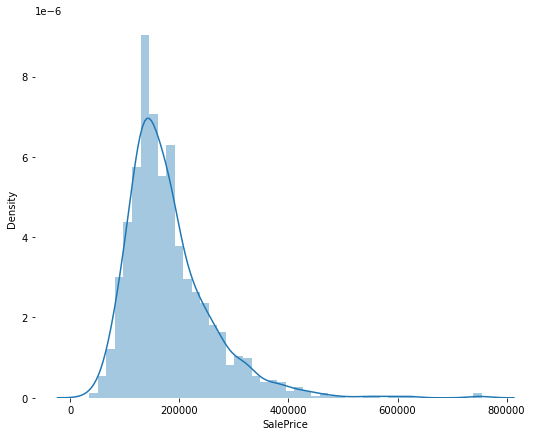

In [23]:
plt.figure(figsize=(9, 7))
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

# plot density
sns.distplot(y)



## Transforming target variable to become more normally distributed

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


mu = 181,156.66 and sigma = 80,069.25


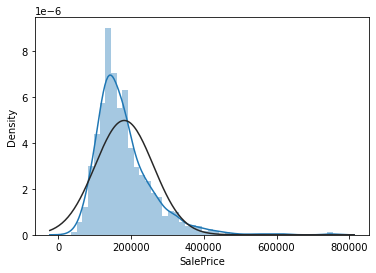

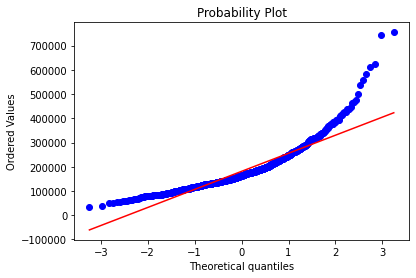

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


transformed mu = 12.03 and transformed sigma = 0.40


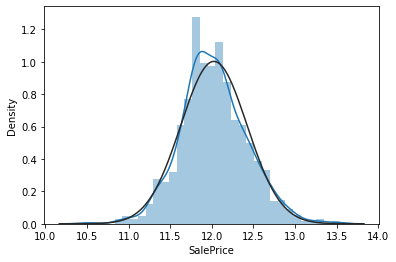

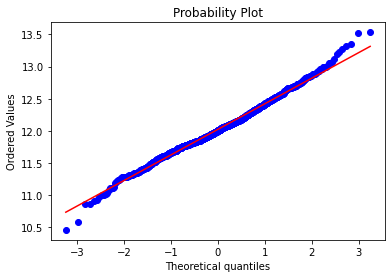

258     11.813030
267     12.279323
288     11.686879
649     11.813030
1233    11.767180
167     13.345507
926     12.278393
831     12.469974
1237    11.002100
426     12.323856
Name: SalePrice, dtype: float64

In [24]:
# Density plot with norm
sns.distplot(y, fit = norm)
(mu, sigma) = norm.fit(y)
print('mu = {:,.2f} and sigma = {:,.2f}'.format(mu,sigma))

# Q-Q plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

# Apply Log transform to SalePrice (y in training data)
y = np.log(y)

# Density plot with norm
sns.distplot(y, fit = norm)
(mu, sigma) = norm.fit(y)
print('transformed mu = {:,.2f} and transformed sigma = {:,.2f}'.format(mu, sigma))

# Q-Q Plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

y.head(10)

In [25]:
# Create features (x)

# all columns except last
all_features = list(train_dataset_imputed.columns[:-1])

X = train_dataset_imputed.copy()[all_features]

# Split into validation and training
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state=1)

test_X = test_dataset_imputed.copy()[all_features]



## One-Hot Encode Categorical Variables

In [26]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 162 to 844
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     934 non-null    int64  
 1   MSZoning       934 non-null    object 
 2   LotFrontage    775 non-null    float64
 3   LotArea        934 non-null    int64  
 4   Street         934 non-null    object 
 5   Alley          60 non-null     object 
 6   LotShape       934 non-null    object 
 7   LandContour    934 non-null    object 
 8   Utilities      934 non-null    object 
 9   LotConfig      934 non-null    object 
 10  LandSlope      934 non-null    object 
 11  Neighborhood   934 non-null    object 
 12  Condition1     934 non-null    object 
 13  Condition2     934 non-null    object 
 14  BldgType       934 non-null    object 
 15  HouseStyle     934 non-null    object 
 16  OverallQual    934 non-null    int64  
 17  OverallCond    934 non-null    int64  
 18  YearBuil

In [27]:
# eligible to be one-hot encoded if it is type object and <30 unique values
low_cardinality_cols_train = [cname for cname in train_X.columns if 
                                train_X[cname].nunique() < 30]

# numerical data if integer or float                                 
numeric_cols_train = [cname for cname in train_X.columns if 
                                train_X[cname].dtype in ['int64', 'float64']]



In [28]:
# function to subtract lists
def subtractlist (a,b):
  result = []
  for x in a:
    if x not in b: 
      result.append(x)
  return result
  
# data set columns as lists
train_X_columns = list(train_X.columns)
test_X_columns = list(test_X.columns)
val_X_columns = list((val_X.columns))

In [29]:
# identity categorical and numeric predictors for each data set
train_categ_predictors = train_X[low_cardinality_cols_train]
train_numer_predictors = train_X[subtractlist(train_X_columns, low_cardinality_cols_train)]

val_categ_predictors = val_X[low_cardinality_cols_train]
val_numer_predictors = val_X[subtractlist(val_X_columns, low_cardinality_cols_train)]

test_categ_predictors = test_X[low_cardinality_cols_train]
test_numer_predictors = test_X[subtractlist(test_X_columns, low_cardinality_cols_train)]

In [30]:
# test if subtractlist works
subtractlist(train_X_columns, low_cardinality_cols_train)

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

## **OHE categorical predictors than concatenated with numeric variables**

In [31]:
# One-hot encode categorical data for training
one_hot_train_categ_predictors = pd.get_dummies(train_categ_predictors)
frames = [one_hot_train_categ_predictors, train_numer_predictors]
one_hot_train_predictors = pd.concat(frames, axis=1)

# One-hot encode categorical data for validation set
one_hot_val_categ_predictors = pd.get_dummies(val_categ_predictors)
frames = [one_hot_val_categ_predictors, val_numer_predictors]
one_hot_val_predictors = pd.concat(frames, axis=1)

# align train and validation
one_hot_train_X, one_hot_val_X = one_hot_train_predictors.align(one_hot_val_predictors, join = 'left', axis=1)

# One-hot encode for test data
one_hot_test_categ_predictors = pd.get_dummies(test_categ_predictors)
frames = [one_hot_test_categ_predictors, test_numer_predictors]
one_hot_test_predictors = pd.concat(frames, axis=1)

one_hot_test_X, one_hot_test_X = one_hot_train_predictors.align(one_hot_test_predictors, join = 'left', axis=1)

# train from this with y
one_hot_X = one_hot_train_X.append(one_hot_val_X)

In [32]:
# check shape all X (train + validation)
one_hot_X

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,...,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
162,20,7,5,0,1,0,2,0,3,1,8,0,2,0,0,0,4,2008,0,0,0,1,0,0.0,1,0,0,0,0,0,1,0,0,0,1,1,0.0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,1,0,0,0,1,0,65.0,8450,2004,2004,266.0,946,0,490,1436,1436,0,1436,2004.0,484,139,98,0,0
347,20,7,5,0,0,0,2,0,3,1,6,1,2,0,0,0,4,2009,0,0,0,1,0,0.0,1,0,0,0,0,0,1,0,0,0,1,1,0.0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,1,0,0,1,0,0,85.0,11900,1977,1977,209.0,822,0,564,1386,1411,0,1411,1977.0,544,192,0,0,0
425,160,8,5,0,0,0,2,1,2,1,5,0,2,0,0,0,11,2007,0,1,0,0,0,0.0,1,0,1,0,0,0,1,0,0,0,1,1,0.0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,1,0,0,0,1,0,24.0,2645,1999,2000,456.0,0,0,776,776,764,677,1441,1999.0,492,206,0,0,0
399,60,6,5,0,1,0,2,1,3,1,8,1,2,0,0,0,4,2008,0,0,0,1,0,0.0,1,0,0,1,0,0,0,0,0,0,1,1,0.0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,1,0,0,0,1,0,62.0,7415,2004,2004,0.0,759,0,80,839,864,729,1593,2004.0,398,100,75,0,0
1379,60,10,5,0,0,0,3,1,3,1,10,1,3,0,0,0,10,2006,0,0,0,1,0,0.0,1,0,0,0,1,0,0,0,1,0,0,1,0.0,0,1,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0,0,1,66.0,13682,2006,2006,1031.0,0,0,1410,1410,1426,1519,2945,2006.0,641,192,0,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,20,8,5,0,0,0,2,0,3,1,7,1,2,0,0,0,6,2009,0,0,0,1,0,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,NaN,11838,2001,2001,0.0,0,0,1753,1753,1788,0,1788,2001.0,522,202,151,0,0
147,20,6,7,0,1,0,1,0,2,1,6,0,2,0,0,0,4,2010,0,0,0,0,1,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,90.0,7407,1957,1996,0.0,600,0,312,912,1236,0,1236,1957.0,923,0,158,158,0
1210,20,7,5,0,0,0,2,0,3,1,7,1,2,0,0,0,4,2009,0,0,0,1,0,NaN,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,0,0,0,82.0,11880,1978,1978,206.0,704,0,567,1271,1601,0,1601,1978.0,478,0,0,0,0
1113,30,6,5,0,0,0,1,0,2,1,6,1,1,0,0,0,5,2007,0,0,0,0,1,NaN,1,0,0,0,0,0,1,1,0,0,0,1,NaN,0,0,0,...,NaN,0,0,1,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,59.0,8263,1920,1950,0.0,0,0,1012,1012,1012,0,1012,1920.0,308,0,22,112,0


In [33]:
# check shape train
one_hot_train_X

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,...,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
162,20,7,5,0,1,0,2,0,3,1,8,0,2,0,0,0,4,2008,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,65.0,8450,2004,2004,266.0,946,0,490,1436,1436,0,1436,2004.0,484,139,98,0,0
347,20,7,5,0,0,0,2,0,3,1,6,1,2,0,0,0,4,2009,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,85.0,11900,1977,1977,209.0,822,0,564,1386,1411,0,1411,1977.0,544,192,0,0,0
425,160,8,5,0,0,0,2,1,2,1,5,0,2,0,0,0,11,2007,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,24.0,2645,1999,2000,456.0,0,0,776,776,764,677,1441,1999.0,492,206,0,0,0
399,60,6,5,0,1,0,2,1,3,1,8,1,2,0,0,0,4,2008,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,62.0,7415,2004,2004,0.0,759,0,80,839,864,729,1593,2004.0,398,100,75,0,0
1379,60,10,5,0,0,0,3,1,3,1,10,1,3,0,0,0,10,2006,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,66.0,13682,2006,2006,1031.0,0,0,1410,1410,1426,1519,2945,2006.0,641,192,0,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,20,8,5,0,1,0,2,0,3,1,7,1,3,0,0,0,11,2007,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,93.0,12085,2007,2007,328.0,1004,0,730,1734,1734,0,1734,2007.0,928,0,0,0,0
862,60,8,5,0,1,0,2,1,3,1,7,1,2,0,0,0,11,2009,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN,11885,2001,2001,108.0,990,0,309,1299,1299,573,1872,2001.0,531,160,122,0,0
519,50,5,7,0,1,0,1,1,3,1,7,2,1,0,0,0,6,2007,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,60.0,7200,1937,1950,252.0,569,0,162,731,981,787,1768,1939.0,240,0,0,264,0
894,50,6,4,0,0,0,2,0,4,1,7,0,1,0,0,0,10,2006,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,75.0,9525,1954,1972,0.0,444,0,550,994,1216,639,1855,1954.0,325,182,0,0,0


In [34]:
# check shape val
one_hot_val_X

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,...,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
419,70,7,6,0,0,0,1,1,3,1,6,2,1,0,0,0,7,2007,0,0,0,1,0,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,0,1,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,1,0,75.0,13125,1940,1984,0.0,410,0,390,800,960,780,1740,1940.0,240,0,0,0,0
525,160,6,7,0,0,1,1,1,3,1,7,0,1,0,0,0,5,2006,0,0,0,0,1,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,21.0,1680,1972,1972,281.0,317,0,355,672,672,546,1218,1972.0,264,0,28,0,0
1252,45,5,5,0,0,0,1,0,2,1,5,0,1,0,0,0,6,2007,0,0,0,1,0,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,55.0,10594,1926,1950,0.0,0,0,768,768,789,0,789,1926.0,200,0,0,112,0
22,20,7,5,0,0,0,2,0,3,1,7,0,2,0,0,0,9,2009,0,0,0,1,0,NaN,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,1,NaN,0,0,0,0,0,1,79.0,9541,2009,2009,268.0,0,0,1502,1502,1502,0,1502,2009.0,644,0,114,0,0
393,50,5,3,0,0,0,1,0,5,1,8,0,0,0,0,0,5,2006,0,0,0,1,0,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,1,...,NaN,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,0,0,58.0,8410,1910,1996,0.0,0,0,658,658,658,526,1184,NaN,0,0,151,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,20,8,5,0,0,0,2,0,3,1,7,1,2,0,0,0,6,2009,0,0,0,1,0,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,NaN,11838,2001,2001,0.0,0,0,1753,1753,1788,0,1788,2001.0,522,202,151,0,0
147,20,6,7,0,1,0,1,0,2,1,6,0,2,0,0,0,4,2010,0,0,0,0,1,NaN,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,90.0,7407,1957,1996,0.0,600,0,312,912,1236,0,1236,1957.0,923,0,158,158,0
1210,20,7,5,0,0,0,2,0,3,1,7,1,2,0,0,0,4,2009,0,0,0,1,0,NaN,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,0,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,0,0,0,82.0,11880,1978,1978,206.0,704,0,567,1271,1601,0,1601,1978.0,478,0,0,0,0
1113,30,6,5,0,0,0,1,0,2,1,6,1,1,0,0,0,5,2007,0,0,0,0,1,NaN,1,0,0,0,0,0,1,1,0,0,0,1,NaN,0,0,0,...,NaN,0,0,1,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,1,0,0,0,1,0,59.0,8263,1920,1950,0.0,0,0,1012,1012,1012,0,1012,1920.0,308,0,22,112,0


In [35]:
# check shape test
one_hot_test_X

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,...,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
15,60,6,6,0,0,0,2,1,4,1,8,1,2,0,0,0,7,2008,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,76.0,9120,1974,1974,270.0,442,0,459,901,943,933,1876,1974.0,540,0,69,0,0
20,20,5,5,0,1,0,1,0,3,1,5,1,2,0,0,0,6,2006,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,100.0,13350,1974,1974,0.0,762,0,102,864,894,0,894,1974.0,440,241,0,0,0
21,20,7,5,0,1,0,2,0,3,1,8,1,3,0,0,0,9,2007,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,1,79.0,9416,2007,2007,205.0,1126,0,600,1726,1726,0,1726,2007.0,786,171,138,0,266
24,120,8,5,0,1,0,1,1,2,1,6,1,2,0,0,0,4,2006,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,1,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,30.0,9549,1995,1996,0.0,437,1057,0,1494,1494,0,1494,1995.0,481,0,30,0,216
25,30,5,6,0,1,0,1,0,3,1,6,1,0,0,0,0,7,2008,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,63.0,13907,1940,1969,0.0,290,0,706,996,996,0,996,NaN,0,144,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,120,6,5,0,1,0,1,0,2,1,4,0,1,0,0,0,2,2010,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,50.0,7175,1984,1984,0.0,623,121,0,744,752,0,752,1984.0,264,353,0,0,90
1438,30,3,6,0,0,0,1,0,3,1,6,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,NaN,0,0,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,70.0,4270,1931,2006,0.0,544,0,0,544,774,0,774,NaN,0,0,0,286,0
1455,70,7,9,0,0,0,1,1,3,1,9,2,1,0,0,0,6,2009,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,NaN,0,0,0,...,NaN,0,0,1,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,53.0,10918,1926,2004,0.0,0,0,1276,1276,1276,804,2080,1926.0,282,0,0,0,145
1458,160,7,5,0,1,0,2,0,3,1,6,1,2,0,0,0,9,2007,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,NaN,0,1,0,...,NaN,0,0,0,NaN,0,0,0,0,0,NaN,0,0,0,0,0,1,0,0,0,1,0,NaN,5062,1984,1984,0.0,828,182,180,1190,1190,900,2090,1984.0,577,219,0,0,0


## XG Boost Model and Validation

In [36]:
# initial pass
my_XGB_model = XGBRegressor(objective = 'reg:squarederror')
my_XGB_model.fit(one_hot_train_X, train_y, verbose=False)

# make predictions note we need to np.exp because we log transformed y
XGB_predictions = my_XGB_model.predict(one_hot_val_X)
XGB_predictions_transformed = np.exp(XGB_predictions)

# print MSE for initial XGB model
XGB_mse = mean_squared_error(XGB_predictions_transformed, np.exp(val_y))
print("Validation MSE for XGBoost Model : " + str(XGB_mse))

# additional passes
my_XGB_model = XGBRegressor(n_estimators = 1000, learning_rate = .05, objective = 'reg:squarederror')
my_XGB_model.fit(one_hot_train_X, train_y, early_stopping_rounds = 10,
                eval_set = [(one_hot_val_X, val_y)], verbose = False)
XGB_predictions = my_XGB_model.predict(one_hot_val_X)
XGB_predictions_transformed = np.exp(XGB_predictions)
XGB_mult_mse = mean_squared_error(XGB_predictions_transformed, np.exp(val_y))
print("Validation MSE for multi-pass XGBoost Model: " + str(XGB_mult_mse))


Validation MSE for XGBoost Model : 1457367548.285054
Validation MSE for multi-pass XGBoost Model: 1329075926.884221


# **Results against Test Data**

In [39]:
# predict SalePrice on Test Data:
test_predictions = my_XGB_model.predict(one_hot_test_X)
test_predictions = np.exp(test_predictions)
print('\n\n ---------------------------------------- \n\n')
print(test_predictions)



 ---------------------------------------- 


[175638.53  143734.61  282716.88  268071.28  115082.13  126027.695
 247846.2   206088.33  164366.25  189417.1   182917.89  118804.78
 196670.73  113970.38  102891.71  137560.95  141225.66  149965.34
 149676.72  225184.12  162818.44  348347.8    93103.34  144901.86
 103487.68  338999.6   201268.03  111511.76  110676.05  176871.8
 193389.48  142412.72  397239.97  144120.86  138173.25  101542.
 173483.05  264964.06  192297.8   180266.39  153867.58  147589.1
 115086.74  255394.9   185957.27  121727.29  168612.5   144323.03
 260334.78  222558.31  403162.5   144651.81  121720.78  115334.62
 132082.95  134429.6   199569.25  136165.55  157349.19  182240.56
 134675.6   172697.3   241425.16  423781.4   237998.16  144054.62
 135208.62  208892.22  157394.22  150209.39  189884.08  103249.51
 507166.1   195654.73   86014.59  193437.08   84778.914 118952.62
 174286.81  204914.8   148159.4   364203.34   76947.99  155488.73
 151622.42  257863.84  179172.89

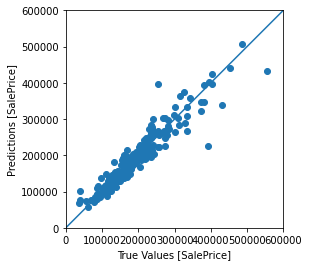

In [40]:
test_labels = test_dataset_imputed['SalePrice']

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
lims = [0, 600000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

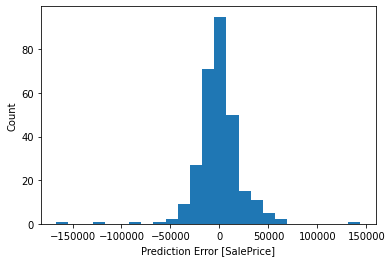

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [SalePrice]")
_ = plt.ylabel("Count")